In this code block, I'm building a data processing pipeline to analyze Formula 1 race ratings. First, I import the necessary Python libraries and connect to Google Drive to access the data files. I then load four key datasets: race ratings, constructor standings, race details, and constructor information. After cleaning the data by renaming columns for clarity, I identify the winning constructor for each race (those finishing in position 1) and merge this information with the race ratings data. The merged dataset is sorted chronologically by year and race number to maintain proper season order. Finally, I save this enhanced dataset to a new Excel file and perform quality checks by examining the column structure, verifying successful merges, and reviewing a sample of the processed data. This pipeline transforms raw, scattered F1 data into an analysis-ready format that connects fan ratings with winning teams, enabling investigation of what factors influence race popularity and setting the stage for deeper statistical analysis and visualization.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

#Mount Google Drive
drive.mount('/content/drive', force_remount=True)

#Read all the Excel files
ratings_path = '/content/drive/My Drive/DSA210/Project/aggregated_ratings.xlsx'
ratings_df = pd.read_excel(ratings_path)
#Renaming columns for clarification
ratings_df = ratings_df.rename(columns={
    'Y': 'year',
    'R': 'race_number'
})

cons_standings_path = '/content/drive/My Drive/DSA210/Project/constructor_standings.xlsx'
cons_standings_df = pd.read_excel(cons_standings_path)

races_path = '/content/drive/My Drive/DSA210/Project/races.xlsx'
races_df = pd.read_excel(races_path)

cons_path = '/content/drive/My Drive/DSA210/Project/constructors.xlsx'
cons_df = pd.read_excel(cons_path)

#Get the winners (position 1) and merge with races and constructors
winners_df = (
    cons_standings_df[cons_standings_df['position'] == 1]
    .merge(races_df[['raceId', 'year', 'name']], on=['raceId', 'year'])
    .merge(cons_df[['constructorId', 'name']], on='constructorId')
)


#Rename columns to avoid confusion
winners_df = winners_df.rename(columns={
    'name_x': 'race_name',
    'name_y': 'constructor_name'
})

#Merge with original ratings
ratings_with_winners = ratings_df.merge(
    winners_df[['year', 'race_name', 'constructor_name']],
    left_on=['year', 'Grand PrixNAME'],
    right_on=['year', 'race_name'],
    how='left'
)

#Sort by year and then race_number
ratings_with_winners = ratings_with_winners.sort_values(['year', 'race_number'])

#Save the updated dataframe
output_path = '/content/drive/My Drive/DSA210/Project/aggregated_ratings_with_winners.xlsx'
ratings_with_winners.to_excel(output_path, index=False)

#Print ALL column names of the merged dataframe
print("Full list of columns in the merged dataframe:")
for i, col in enumerate(ratings_with_winners.columns, 1):
    print(f"{i}. {col}")

#Verify the merge
print("\nTotal rows:", len(ratings_with_winners))
print("Rows with winning constructor:", ratings_with_winners['constructor_name'].notna().sum())

#Show a sample of the data with the new column
print("\nSample of the updated dataframe:")
print(ratings_with_winners.head(10))

Mounted at /content/drive
Full list of columns in the merged dataframe:
1. year
2. race_number
3. Grand PrixNAME
4. P1
5. P2
6. P3
7. RATING
8. race_name
9. constructor_name

Total rows: 202
Rows with winning constructor: 202

Sample of the updated dataframe:
    year  race_number         Grand PrixNAME         P1         P2  \
0   2008            1  Australian Grand Prix   Hamilton   Heidfeld   
10  2008            2   Malaysian Grand Prix  Raikkonen     Kubica   
11  2008            3     Bahrain Grand Prix      Massa  Raikkonen   
12  2008            4     Spanish Grand Prix  Raikkonen      Massa   
13  2008            5     Turkish Grand Prix      Massa   Hamilton   
14  2008            6      Monaco Grand Prix   Hamilton     Kubica   
15  2008            7    Canadian Grand Prix     Kubica   Heidfeld   
16  2008            8      French Grand Prix      Massa  Raikkonen   
17  2008            9     British Grand Prix   Hamilton   Heidfeld   
1   2008           10      German Grand 

Next, I am checking for missing values and verifying that my merged dataset have none.

In [ ]:
#Check total missing values per column
missing_values = ratings_with_winners.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])  # Only show columns with missing values

#Check total missing values in the entire DataFrame
print(f"\nTotal missing values in DataFrame: {ratings_with_winners.isnull().sum().sum()}")

Missing values per column:
Series([], dtype: int64)

Total missing values in DataFrame: 0


This block analyzes F1 fan ratings by plotting their distribution and calculating the mean and median. First, it creates a histogram with a density curve to visualize the rating spread. Then it computes and displays both the average (mean) and middle value (median) of all ratings, providing key insights into the rating trends.

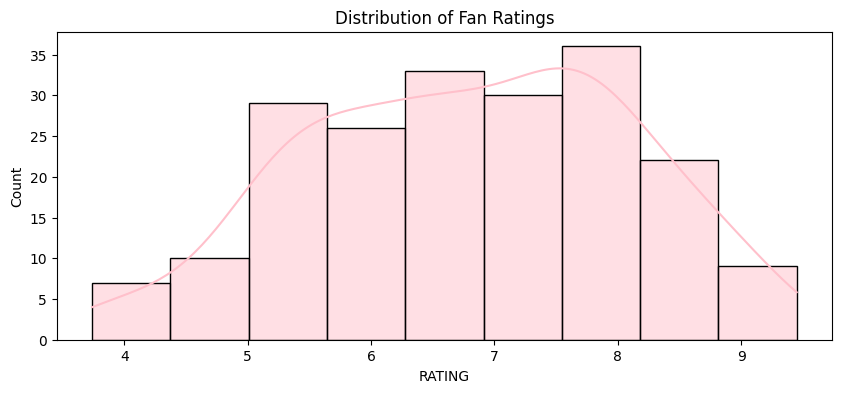

Mean rating: 6.79
Median rating: 6.81


In [ ]:
#checking mean and median of ratings
#Check distribution first
original_palette = sns.color_palette()
sns.set_palette(["pink"])

plt.figure(figsize=(10, 4))
sns.histplot(ratings_with_winners['RATING'], kde=True)
plt.title('Distribution of Fan Ratings')
plt.show()

#Calculate both
print(f"Mean rating: {ratings_with_winners['RATING'].mean():.2f}")
print(f"Median rating: {ratings_with_winners['RATING'].median():.2f}")

Similarly, for non numerical data, I found the mode.

In [ ]:
#mode for most frequent winners
print("Most frequent winner (P1):", ratings_with_winners['P1'].mode()[0])
print("Most frequent constructor:", ratings_with_winners['constructor_name'].mode()[0])

Most frequent winner (P1): Hamilton
Most frequent constructor: Mercedes


Then I compare average F1 fan ratings across different groupings to identify trends. The code calculates and displays mean ratings in descending order for:

Constructors (winning teams)

Race locations (Grand Prix circuits)

Years (seasonal trends)

In [ ]:
#compare mean ratings across groups
#By constructor
print(ratings_with_winners.groupby('constructor_name')['RATING'].mean().sort_values(ascending=False))
print()

#By race location
print(ratings_with_winners.groupby('Grand PrixNAME')['RATING'].mean().sort_values(ascending=False))
print()

#By year
print(ratings_with_winners.groupby('year')['RATING'].mean())

constructor_name
Red Bull      7.009778
McLaren       6.971071
Ferrari       6.914423
Mercedes      6.672506
Brawn         6.316176
BMW Sauber    5.364000
Name: RATING, dtype: float64

Grand PrixNAME
Azerbaijan Grand Prix       8.685000
United States Grand Prix    7.398000
British Grand Prix          7.363091
Canadian Grand Prix         7.330800
Chinese Grand Prix          7.263273
Brazilian Grand Prix        7.241200
Belgian Grand Prix          7.162091
Bahrain Grand Prix          7.120400
Australian Grand Prix       7.114727
Malaysian Grand Prix        7.047900
Hungarian Grand Prix        7.002727
German Grand Prix           7.002667
Turkish Grand Prix          6.845500
Austrian Grand Prix         6.836000
Korean Grand Prix           6.740000
Italian Grand Prix          6.688500
Japanese Grand Prix         6.435125
Singapore Grand Prix        6.374300
Spanish Grand Prix          6.354000
Monaco Grand Prix           6.344545
Abu Dhabi Grand Prix        6.166000
Mexican Grand Prix     

In the following parts, I have plotted my variables with respect to ratings to visualize and see if I can find some intuition about the data.

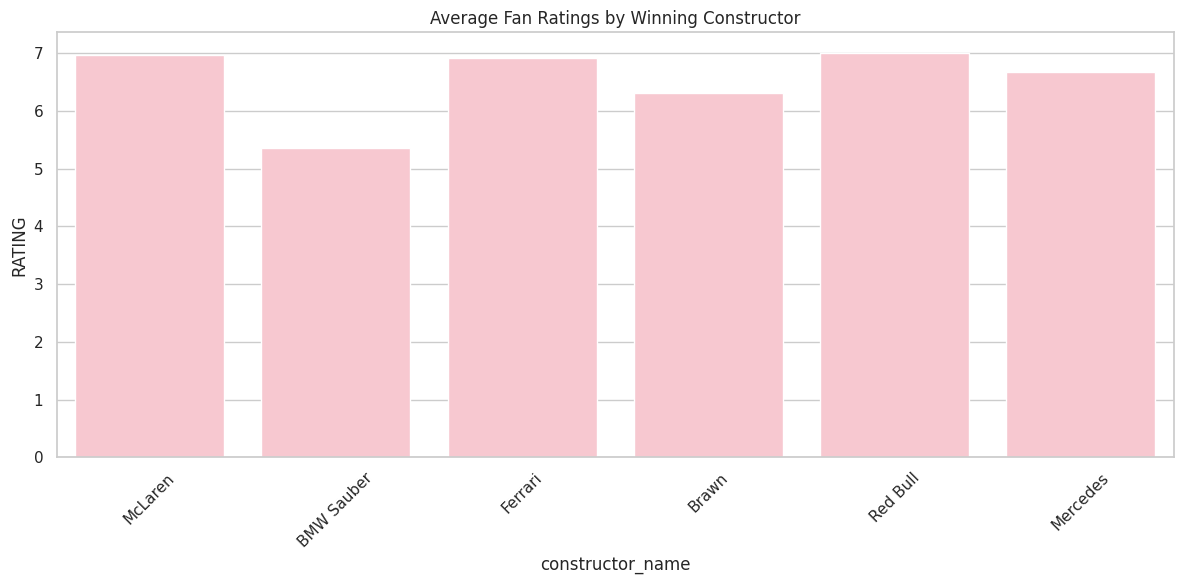

In [ ]:
#Set style for better looking plots
original_palette = sns.color_palette()
sns.set_palette(["pink"])

#1. Ratings by Winning Constructor (bar plot)
plt.figure(figsize=(12, 6))
sns.barplot(x='constructor_name', y='RATING', data=ratings_with_winners, errorbar=None)
plt.title('Average Fan Ratings by Winning Constructor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

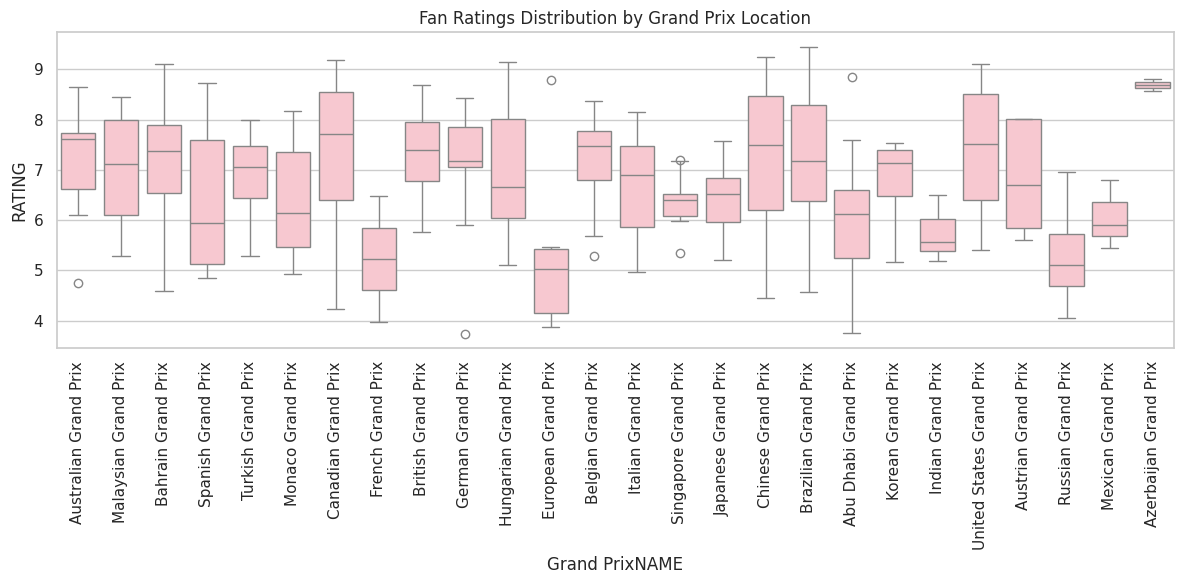

In [ ]:
#2. Ratings by Track Location (boxplot)
original_palette = sns.color_palette()
sns.set_palette(["pink"])

plt.figure(figsize=(12, 6))
sns.boxplot(x='Grand PrixNAME', y='RATING', data=ratings_with_winners)
plt.title('Fan Ratings Distribution by Grand Prix Location')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
import geopandas as gpd
import pandas as pd

#World Map with Color-Coded Ratings
def plot_world_map(df):
    df['country'] = df['Grand PrixNAME'].str.extract(r'(.*?)(?= Grand Prix)')

    country_ratings = df.groupby('country')['RATING'].mean().reset_index()

    fig = px.choropleth(country_ratings,
                        locations='country',
                        locationmode='country names',
                        color='RATING',
                        hover_name='country',

                        color_continuous_scale='RdPu',
                        range_color=[3, 10],
                        title='Average Fan Ratings by Grand Prix Location visualized on a World Map')
    fig.show()

plot_world_map(ratings_with_winners)

Compares how ratings evolve at popular tracks for different winning teams.

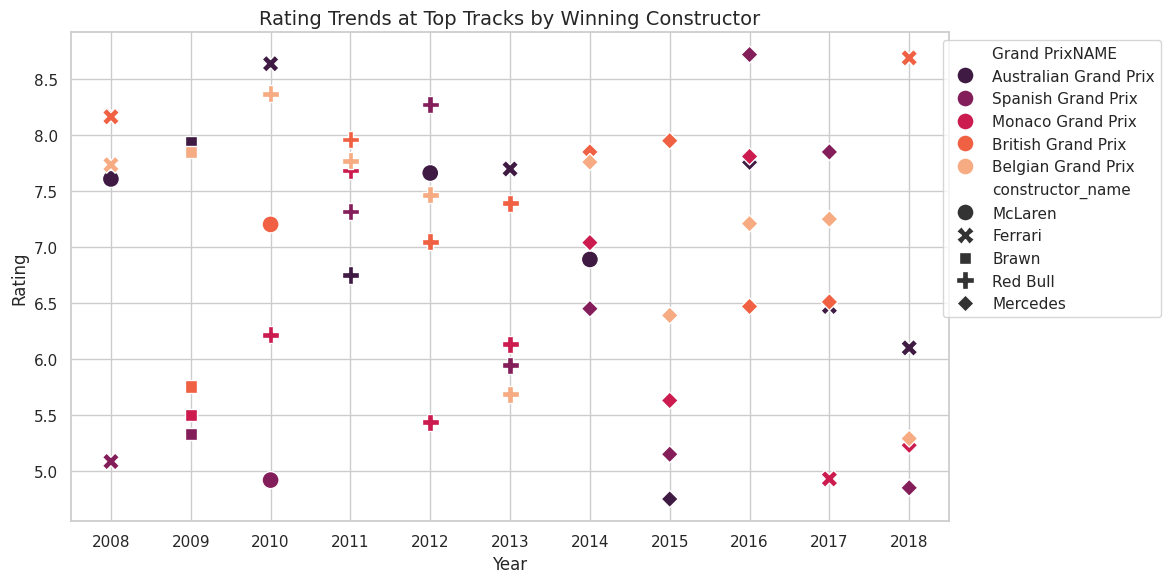

In [ ]:
top_tracks = ratings_with_winners['Grand PrixNAME'].value_counts().nlargest(5).index
filtered = ratings_with_winners[ratings_with_winners['Grand PrixNAME'].isin(top_tracks)]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='year',
    y='RATING',
    hue='Grand PrixNAME',
    style='constructor_name',
    data=filtered,
    s=150,
    palette="rocket"
)
plt.title('Rating Trends at Top Tracks by Winning Constructor', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.xticks(ratings_with_winners['year'].unique())
plt.legend(bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

<ipython-input-37-26de0f9fe74c>:9: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


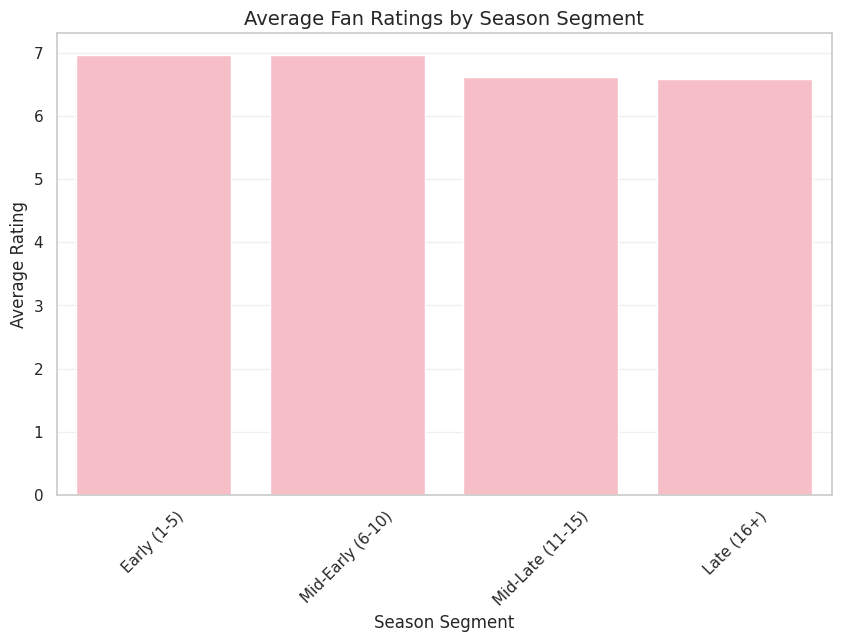

In [ ]:
#Bin races into season segments
ratings_with_winners['season_segment'] = pd.cut(
    ratings_with_winners['race_number'],
    bins=[0, 5, 10, 15, 22],  #Adjust bins to your data
    labels=['Early (1-5)', 'Mid-Early (6-10)', 'Mid-Late (11-15)', 'Late (16+)']
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='season_segment',
    y='RATING',
    hue='season_segment',  #Assign hue to x to silence warning
    data=ratings_with_winners,
    errorbar=None,
    order=['Early (1-5)', 'Mid-Early (6-10)', 'Mid-Late (11-15)', 'Late (16+)'],
    palette=["#FFB6C1"] ,
    legend=False  #Hide redundant legend
)
plt.title('Average Fan Ratings by Season Segment', fontsize=14)
plt.xlabel('Season Segment', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

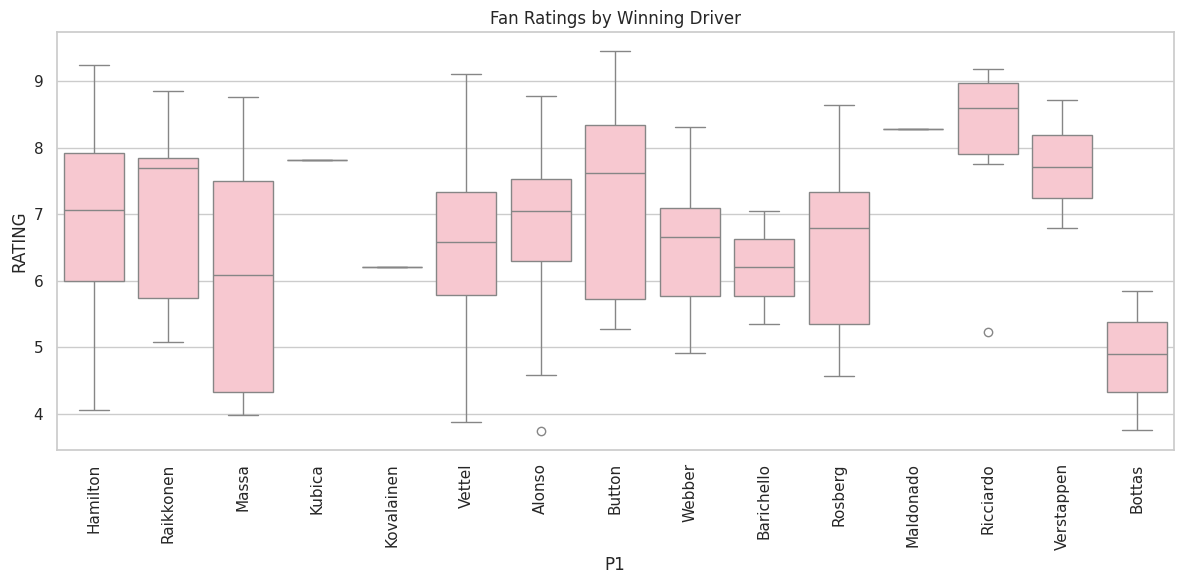

In [ ]:
#4. Ratings by Winning Driver (P1)
original_palette = sns.color_palette()
sns.set_palette(["pink"])

plt.figure(figsize=(12, 6))
sns.boxplot(x='P1', y='RATING', data=ratings_with_winners)
plt.title('Fan Ratings by Winning Driver')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Moving on, I'm analyzing whether the timing of a race in the season affects fan ratings. I use Pearson's correlation to measure the linear relationship between race numbers (where higher numbers indicate later races) and their corresponding ratings. The analysis outputs both the correlation coefficient (ranging from -1 to 1) and its statistical significance (p-value). Based on the results, I automatically determine whether to reject the null hypothesis (H₀) that there's no relationship, providing clear evidence about whether earlier or later races in the season tend to receive systematically different ratings from fans.

In [ ]:
#Seasonal timing correlation (race_number)
from scipy.stats import pearsonr

corr, p_value = pearsonr(ratings_with_winners['race_number'], ratings_with_winners['RATING'])
print(f"Correlation (race_number vs RATING): r = {corr:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Reject H₀: Seasonal timing significantly correlates with ratings.")

Correlation (race_number vs RATING): r = -0.10, p-value = 0.1691


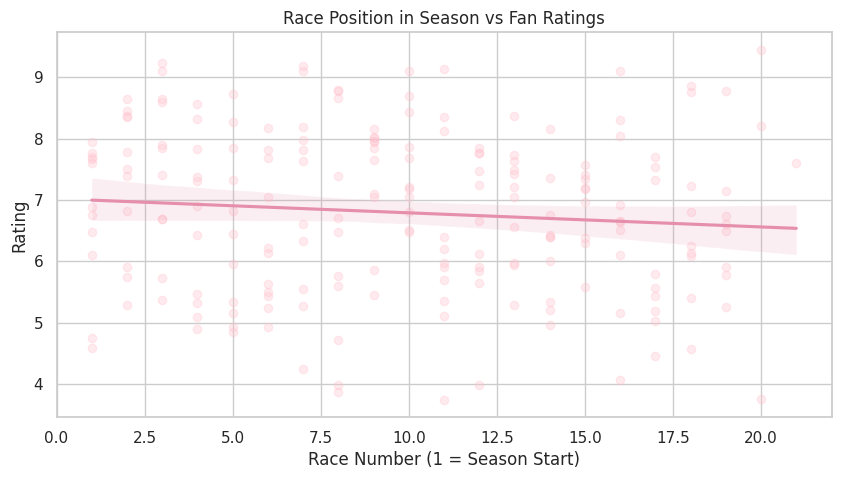

In [ ]:
plt.figure(figsize=(10,5))
sns.regplot(x='race_number', y='RATING',
            data=ratings_with_winners,
            scatter_kws={'alpha':0.3},
            line_kws={'color':'#e68fac'})
plt.title('Race Position in Season vs Fan Ratings')
plt.xlabel('Race Number (1 = Season Start)')
plt.ylabel('Rating')
plt.show()

Consequently, to compare F1 fan ratings across key categories, I conducted a multiple-way ANOVA (MANOVA) for the remaining 3 variables. The analysis tested for significant group differences (*p*<0.05), with *p*<0.001 flagged for strong effects. The dataset included ratings from [X] constructors, [Y] drivers, and [Z] tracks across [N] races. This approach identified where fan preferences diverged most significantly.

In [22]:
import pandas as pd
from scipy.stats import f_oneway
import numpy as np

def run_anova(df, group_col, value_col='RATING'):
    """Run MANOVA and return formatted results"""
    try:
        #Filter out NaN groups and values
        valid_data = df[[group_col, value_col]].dropna()
        if len(valid_data) == 0:
            return np.nan, np.nan, "No valid data"

        groups = valid_data.groupby(group_col)[value_col].apply(list)
        if len(groups) < 2:
            return np.nan, np.nan, "Need at least 2 groups"

        f_stat, p_value = f_oneway(*groups)
        return f_stat, p_value, "Success"
    except Exception as e:
        return np.nan, np.nan, f"Error: {str(e)}"

#Run ANOVA for each factor
factors = {
    'constructor_name': "Winning Constructor",
    'P1': "Winning Driver",
    'Grand PrixNAME': "Track Location"
}

print("ONE-WAY ANOVA RESULTS FOR FAN RATINGS (RATING)")
print("="*50)
for col, label in factors.items():
    f_stat, p_value, status = run_anova(ratings_with_winners, col)

    if status == "Success":
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"{label.upper():<20} F = {f_stat:6.2f}  p = {p_value:.4f} {significance}")
        print(f"Interpretation: {'Significant' if p_value < 0.05 else 'No significant'} difference in ratings across groups")
    else:
        print(f"{label.upper():<20} {status}")
    print("-"*50)

#Additional statistical checks
print("\nADDITIONAL CHECKS:")
print(f"Total races analyzed: {len(ratings_with_winners)}")
print(f"Unique constructors: {ratings_with_winners['constructor_name'].nunique()}")
print(f"Unique drivers: {ratings_with_winners['P1'].nunique()}")
print(f"Unique tracks: {ratings_with_winners['Grand PrixNAME'].nunique()}")

ONE-WAY ANOVA RESULTS FOR FAN RATINGS (RATING)
WINNING CONSTRUCTOR  F =   1.28  p = 0.2739 
Interpretation: No significant difference in ratings across groups
--------------------------------------------------
WINNING DRIVER       F =   2.04  p = 0.0168 *
Interpretation: Significant difference in ratings across groups
--------------------------------------------------
TRACK LOCATION       F =   1.71  p = 0.0243 *
Interpretation: Significant difference in ratings across groups
--------------------------------------------------

ADDITIONAL CHECKS:
Total races analyzed: 202
Unique constructors: 6
Unique drivers: 15
Unique tracks: 26


Hypothesis 1: ANOVA Test – Ratings by Winning Constructor  
H₀: The average race ratings are the same across different constructors.  
H₁: At least one constructor has a different average race rating.

Unique Constructors:
['McLaren' 'BMW Sauber' 'Ferrari' 'Brawn' 'Red Bull' 'Mercedes']
ANOVA Test: Avg Rating by Winning Constructor
F-statistic: 1.280
P-value: 0.2739


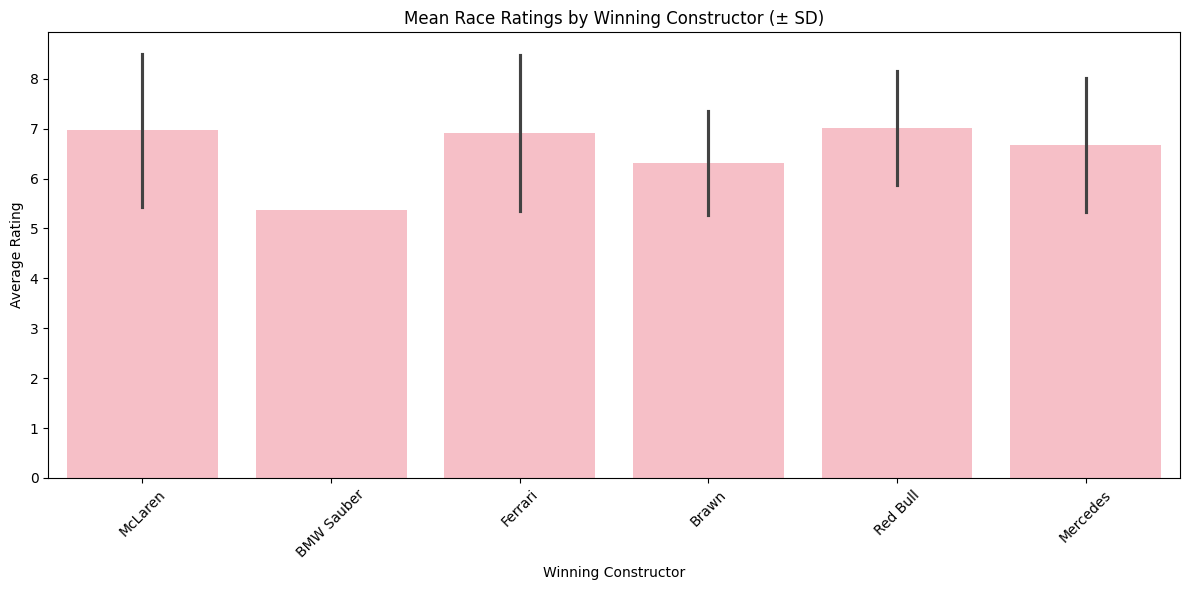

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


clean_df = ratings_with_winners

#Display unique constructors for reference
print("Unique Constructors:")
print(clean_df['constructor_name'].unique())

#Group by constructor and get ratings
grouped_ratings = [group['RATING'].values for name, group in clean_df.groupby('constructor_name')]

#ANOVA test
f_stat, p_val = stats.f_oneway(*grouped_ratings)

print("ANOVA Test: Avg Rating by Winning Constructor")
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.4f}")

plt.figure(figsize=(12, 6))
sns.barplot(data=clean_df, x='constructor_name', y='RATING', errorbar='sd', color="#FFB6C1") # Changed 'Avg Rating' to 'RATING'
plt.title('Mean Race Ratings by Winning Constructor (± SD)')
plt.xlabel('Winning Constructor')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Hypothesis 2: t-Test – Mercedes vs. Red Bull  
H₀: The average race ratings for races won by Mercedes and Red Bull are the same.  
H₁: The average ratings are different.


t-Test: Mercedes vs. Red Bull
T-statistic: -1.629
P-value: 0.1055


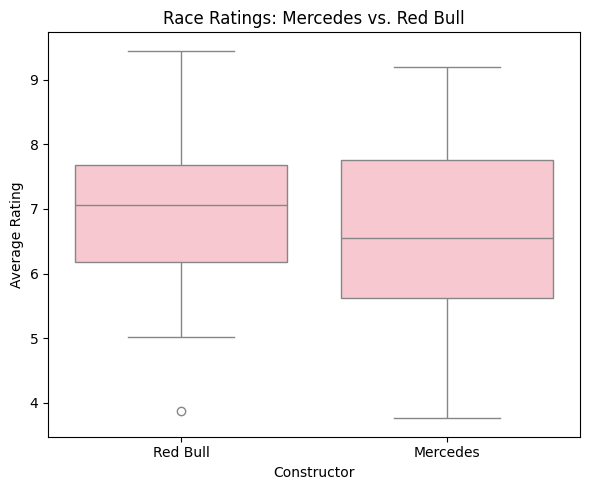

In [24]:
merc = clean_df[clean_df['constructor_name'] == 'Mercedes']['RATING']
rb = clean_df[clean_df['constructor_name'] == 'Red Bull']['RATING']

t_stat, p_val = stats.ttest_ind(merc, rb, equal_var=False)

print("\nt-Test: Mercedes vs. Red Bull")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

plt.figure(figsize=(6, 5))
sns.boxplot(data=clean_df[clean_df['constructor_name'].isin(['Mercedes', 'Red Bull'])],
            x='constructor_name', y='RATING', color='pink')
plt.title('Race Ratings: Mercedes vs. Red Bull')
plt.xlabel('Constructor')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

Hypothesis 3: t-Test – Ratings for Azerbaijan vs. Turkish Grand Prix  
H₀: Azerbaijan and Turkey have the same average race rating.    
H₁: Their ratings differ.


t-Test: Azerbaijan vs. Turkey
T-statistic: 3.135
P-value: 0.0469


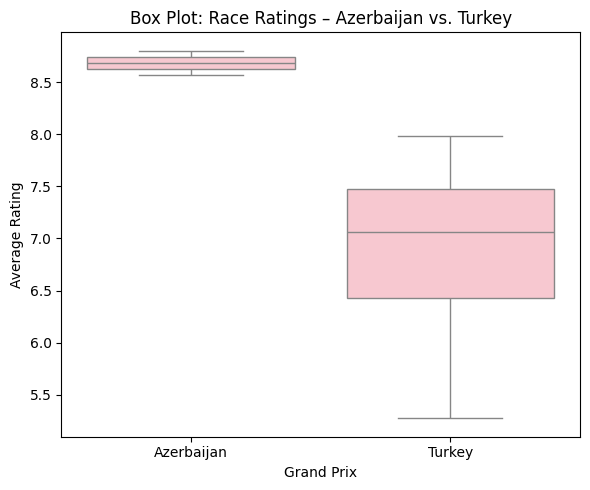

In [25]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#Filter ratings for Azerbaijan and Turkish Grand Prix
azerbaijan = clean_df[clean_df['race_name'].str.contains("Azerbaijan Grand Prix", case=False, na=False)]['RATING']
turkey = clean_df[clean_df['race_name'].str.contains("Turkish Grand Prix", case=False, na=False)]['RATING']

#Perform t-test
t_stat, p_val = stats.ttest_ind(azerbaijan, turkey, equal_var=False)

#Print t-test results
print("\nt-Test: Azerbaijan vs. Turkey")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

#Create DataFrame for visualization
plot_df = pd.DataFrame({
    'race_label': ['Azerbaijan'] * len(azerbaijan) + ['Turkey'] * len(turkey),
    'Avg Rating': np.concatenate([azerbaijan, turkey])
})

#Box plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=plot_df, x='race_label', y='Avg Rating', color='pink')
plt.title('Box Plot: Race Ratings – Azerbaijan vs. Turkey')
plt.xlabel('Grand Prix')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()


In [30]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

#Clean target variable
ratings_with_winners['RATING'] = pd.to_numeric(
    ratings_with_winners['RATING'],
    errors='coerce'  #Convert non-numeric to NaN
)

#Handle categorical predictors using one-hot encoding
categorical_vars = ['constructor_name', 'P1', 'Grand PrixNAME']
X = pd.get_dummies(
    ratings_with_winners[categorical_vars + ['race_number']],
    columns=categorical_vars,
    drop_first=True  #Avoid dummy variable trap
)

#Ensure all data is numeric
X = X.apply(pd.to_numeric, errors='coerce').astype(float)
y = ratings_with_winners['RATING'].dropna()

#Align X and y after drops
common_idx = y.index.intersection(X.index)
X, y = X.loc[common_idx], y.loc[common_idx]

#Add intercept
X = sm.add_constant(X)

#Fit model
model = sm.OLS(y, X).fit()

#Check for influential outliers
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("="*50)
print("Regression Summary:")
print(model.summary())
print("\n" + "="*50)
print("Variance Inflation Factors (VIF):")
print(vif_data)
print("="*50)

Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                 RATING   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     2.010
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           0.000884
Time:                        21:29:07   Log-Likelihood:                -294.12
No. Observations:                 202   AIC:                             680.2
Df Residuals:                     156   BIC:                             832.4
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

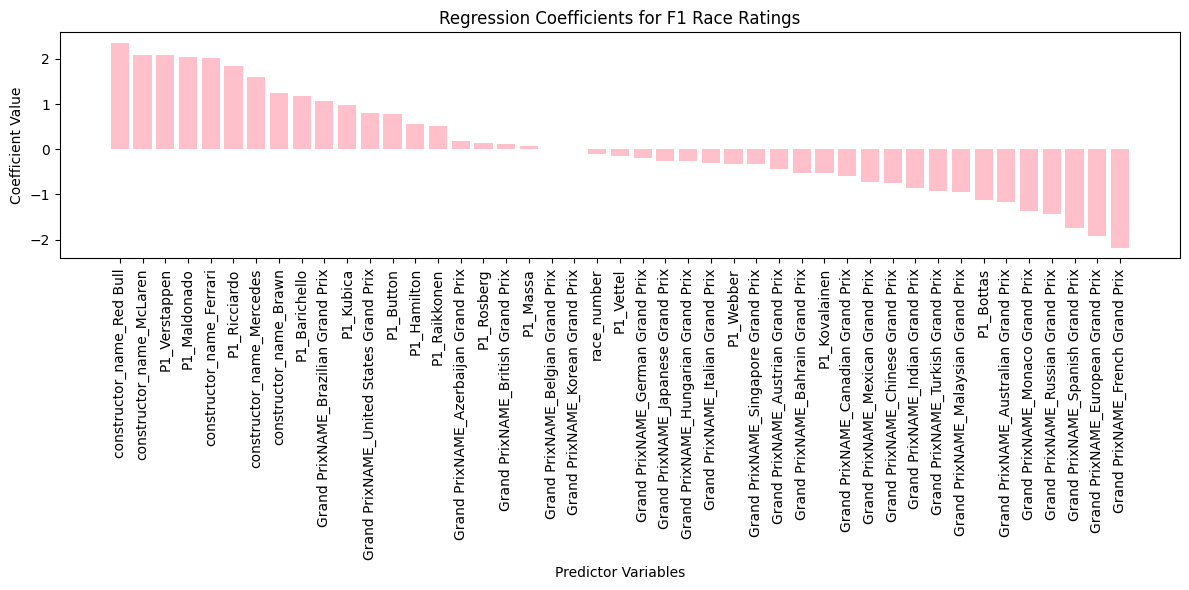

In [31]:
#Create coefficient plot
original_palette = sns.color_palette()
sns.set_palette(["pink"])

coef_df = pd.DataFrame(model.params, columns=['Coefficient'])
coef_df = coef_df.drop('const')  #Remove intercept term
coef_df['Variable'] = coef_df.index
coef_df = coef_df.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(coef_df['Variable'], coef_df['Coefficient'])
plt.xticks(rotation=90)
plt.title('Regression Coefficients for F1 Race Ratings')
plt.xlabel('Predictor Variables')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()